Utilizaremos un set de datos de las policias de New York del año 2009 y
2010. (2009_1perc.csv y 2010_1perc.csv) los cuales nos darán información
de los procedimientos policiales realizados. Además se le entregará el
diccionario de variables para que pueda consultar que significa cada
categoría dentro de las variables.
● La variable respuesta 'arstmade' informa si los procedimientos policiales
han terminado en arresto o no, y el objetivo será realizar un modelo de
Machine Learning para predecir si un futuro procedimiento terminará en
arresto.

In [1]:
#importaciones y set up
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import datasets, svm
from sklearn.metrics import classification_report, confusion_matrix
import itertools
import numpy as np
df2009 = pd.read_csv('2009_1perc.csv')
df2010 = pd.read_csv('2010_1perc.csv')

procedures = pd.concat([df2009, df2010], ignore_index=True)



In [2]:
procedures.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11825 entries, 0 to 11824
Columns: 112 entries, Unnamed: 0 to detailcm
dtypes: float64(1), int64(16), object(95)
memory usage: 10.1+ MB


In [3]:
procedures.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,11825.0,2.959838e+05,1.708207e+05,52.0,147515.0,296652.0,443097.0,601281.0
year,11825.0,2.009508e+03,4.999489e-01,2009.0,2009.0,2010.0,2010.0,2010.0
pct,11825.0,6.862562e+01,3.303783e+01,1.0,42.0,73.0,102.0,123.0
ser_num,11825.0,5.697994e+03,5.152486e+03,1.0,2002.0,4366.0,7840.0,31694.0
datestop,11825.0,6.364221e+06,3.429091e+06,1012009.0,3232009.0,6162010.0,9232009.0,12312010.0
timestop,11825.0,1.413725e+03,7.447264e+02,0.0,1000.0,1605.0,2035.0,2830.0
perobs,11825.0,2.654391e+00,9.759031e+00,0.0,1.0,1.0,3.0,926.0
perstop,11825.0,5.649556e+00,9.758535e+00,1.0,3.0,5.0,5.0,857.0
compyear,11825.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0
comppct,11825.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0


3.- Preprocesamiento de datos
Habrá notado que los datos parecen tener ciertas inconsistencias. Siga los
siguientes pasos para limpiar este set:

- 3.1 Obtenga una lista con todas las variables categoricas que tengan entre 2 y 99 categorías (inclusive). (hint: son las variables tipo categoricas

In [4]:
#utilidades para determinar variables categoricas
def count_freq(df, selected_columns):
    return {i: df[i].unique().shape[0] for i in selected_columns}
def infer_datatype(df, datatype, drop_none=True):
    tmp_list = [i if df[i].dtype == datatype else None for i in df.columns]
    if drop_none is True:
        tmp_list = list(filter(lambda x: x != None, tmp_list))

    return tmp_list

#determinar variables categoricas

object_data_type = infer_datatype(procedures, 'object')
integer_data_type = infer_datatype(procedures, 'int')
float_data_type = infer_datatype(procedures, 'float')

object_unique_vals = count_freq(procedures, object_data_type)
int_unique_vals = count_freq(procedures, integer_data_type)
float_unique_vals = count_freq(procedures, float_data_type)

ListaVariableCategorica = dict(filter(lambda x: x[1] < 100 and x[1] >= 2, object_unique_vals.items()))
ListaVariableCategorica = list(ListaVariableCategorica.keys())
ListaVariableCategorica

['recstat',
 'inout',
 'trhsloc',
 'typeofid',
 'explnstp',
 'othpers',
 'arstmade',
 'sumissue',
 'offunif',
 'officrid',
 'frisked',
 'searched',
 'contrabn',
 'pistol',
 'riflshot',
 'asltweap',
 'knifcuti',
 'othrweap',
 'pf_hands',
 'pf_wall',
 'pf_grnd',
 'pf_drwep',
 'pf_ptwep',
 'pf_baton',
 'pf_hcuff',
 'pf_pepsp',
 'pf_other',
 'radio',
 'ac_rept',
 'ac_inves',
 'rf_vcrim',
 'rf_othsw',
 'ac_proxm',
 'rf_attir',
 'cs_objcs',
 'cs_descr',
 'cs_casng',
 'cs_lkout',
 'rf_vcact',
 'cs_cloth',
 'cs_drgtr',
 'ac_evasv',
 'ac_assoc',
 'cs_furtv',
 'rf_rfcmp',
 'ac_cgdir',
 'rf_verbl',
 'cs_vcrim',
 'cs_bulge',
 'cs_other',
 'ac_incid',
 'ac_time',
 'rf_knowl',
 'ac_stsnd',
 'ac_other',
 'sb_hdobj',
 'sb_outln',
 'sb_admis',
 'sb_other',
 'rf_furt',
 'rf_bulg',
 'offverb',
 'offshld',
 'sex',
 'race',
 'haircolr',
 'eyecolor',
 'build',
 'addrtyp',
 'city',
 'sector',
 'beat',
 'dettypcm',
 'linecm']

-  3.2 Reemplaze las siguientes clases faltantes: 
    - Si alguna categoría de las columnas officrid, offshld o offverb es igual a "" cambielo a 'N' y en caso contrario dejelo como 'Y'

In [5]:
procedures['officrid'].values

array([' ', ' ', ' ', ..., ' ', 'I', ' '], dtype=object)

In [6]:
procedures[['officrid', 'offshld', 'offverb']] = procedures[['officrid', 'offshld', 'offverb']].fillna('N').applymap(lambda x: 'N' if x != 'Y' else x)
procedures['officrid'].values

array(['N', 'N', 'N', ..., 'N', 'N', 'N'], dtype=object)

-Si alguna categoría de las columnas sector, trhsloc o beat es igual a "" (o NA,
dependiendo de como haya catgado la base de datos), cambielo a 'U' y en caso
contrario mantenga su valor
Nota, los valores significan {N: No, Y: Yes, U: Unknown}

In [7]:
procedures['sector'].values

array(['G', 'J', 'E', ..., 'E', 'E', 'H'], dtype=object)

In [8]:
procedures[['sector', 'trhsloc', 'beat']] = procedures[['sector', 'trhsloc', 'beat']].fillna('U')
procedures['sector'].values

array(['G', 'J', 'E', ..., 'E', 'E', 'H'], dtype=object)

- 3.3 Transforme las columnas ht_feet junto con ht_inch en una única columna (de la forma "ht_feet.ht_inch") llamado 'meters' (hint: transforme con el siguiente cálculo: metros = (pies+pulgadas)*0.3048)

In [9]:
procedures['ht_meters'] = (procedures['ht_feet'] + procedures['ht_inch']) * 0.3048
procedures['ht_meters'].values


array([4.2672, 3.048 , 2.7432, ..., 1.8288, 4.8768, 2.1336])

- 3.4 Note que la fecha viene en un formato MMDDAAAA en la columna datestop. Genere 2 nuevas columnas llamadas month y year que solo tenga el mes y el año respectivamente. Hint: Explore la libreria lubridate https://www.rstudio.com/resources/cheatsheets/

In [10]:
procedures['datestop'] = pd.to_datetime(procedures['datestop'], format='%m%d%Y')
procedures['datestop_year'] = procedures['datestop'].dt.year
procedures['datestop_month'] = procedures['datestop'].dt.month


3.5 Filtre su DataFrame y solo deje las columnas seleccionadas en el punto
3.1, el mes, el año, los metros y la edad. Luego solo deje los registros cuyas
edades esten entre 18 y 100 años, ambos inclusive.

In [11]:
filtered_df = procedures[[*ListaVariableCategorica, 'datestop_month', 'datestop_year', 'age']][(procedures['age'] >= 18) & (procedures['age'] <= 100)]
filtered_df.shape

(10078, 77)

Estudie la variable respuesta por si sola (arstmade), puede ayudarse de un gráfico. Comente

In [12]:
filtered_df['arstmade'].values

array(['N', 'N', 'N', ..., 'N', 'N', 'N'], dtype=object)

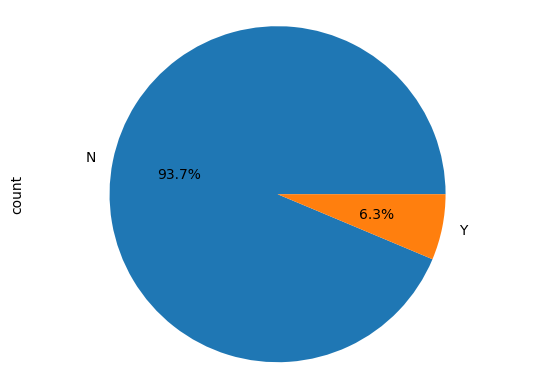

In [13]:
colors = sns.color_palette('pastel')[0:5]
value_counts = procedures['arstmade'].value_counts()
value_counts.plot.pie(autopct='%1.1f%%',)
plt.axis('equal') 
plt.show()

Se puede observar que solo el 6.3% de los procedimientos terminan en arresto en mayores de edad. Por si solo este dato no nos da mucha informacion habria que balancearlo con otras variables o compararlo con otras epocas para analizar el como evoluciona, ademas de contrastarlo con coyonturas sociales que pueden afectar este valor para tener un analisis mas profundo.

4.2.- Estudie la relación de la variable respuesta en comportamiento con la
raza (race), comente.

In [14]:
#agrupar los datos para el grafico
grouped_counts = filtered_df.groupby('race')['arstmade'].value_counts()
grouped_counts = grouped_counts.reset_index().sort_values(by='count', ascending=False)
grouped_counts

,race,arstmade,count
2,B,N,5006
7,Q,N,2368
11,W,N,902
5,P,N,540
3,B,Y,336
0,A,N,279
13,Z,N,234
8,Q,Y,164
12,W,Y,72
9,U,N,66


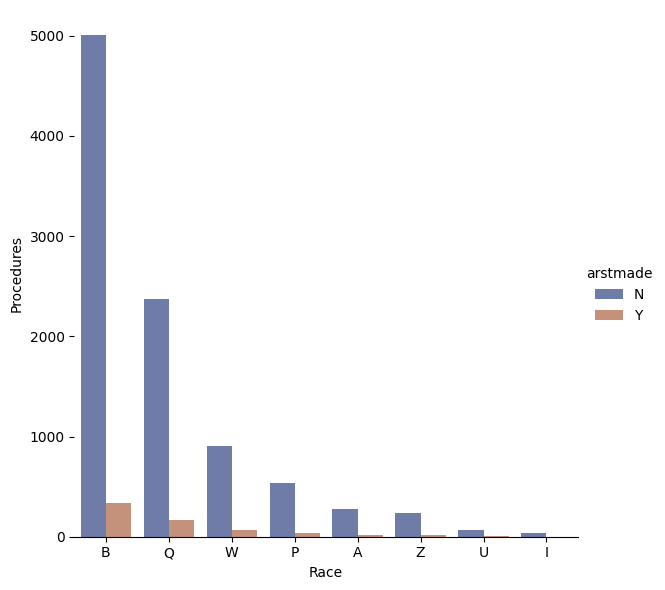

In [15]:
#grafico
g = sns.catplot(
    data=grouped_counts, kind="bar",
    x="race", y="count", hue="arstmade",
    errorbar="sd", palette="dark", alpha=.6, height=6
)
g.despine(left=True)
g.set_axis_labels("Race", "Procedures")

Es observable la diferencia entre razas de los procedimientos realizados, en muchos casos puede ser el doble o mas las posibilidades de ser detenido dependiendo de la raza.
Esto podria indicar al menos usando solo este dato que hay un alto sezgo de ser detenido solo usando esta variable, seria interesante observar como contrasta este dato con
los otros si influye de alguna manera por ejemplo el lugar, edad o el tipo de procedimiento.

4.3 Estudie la relación de la variable respuesta en comportamiento con la
sexo (sex), comente.

In [16]:
#agrupar los datos para el grafico
grouped_counts_by_sex = filtered_df.groupby('sex')['arstmade'].value_counts()
grouped_counts_by_sex = grouped_counts_by_sex.reset_index().sort_values(by='sex')
grouped_counts_by_sex

,sex,arstmade,count
0,F,N,586
1,F,Y,64
2,M,N,8704
3,M,Y,574
4,Z,N,142
5,Z,Y,8


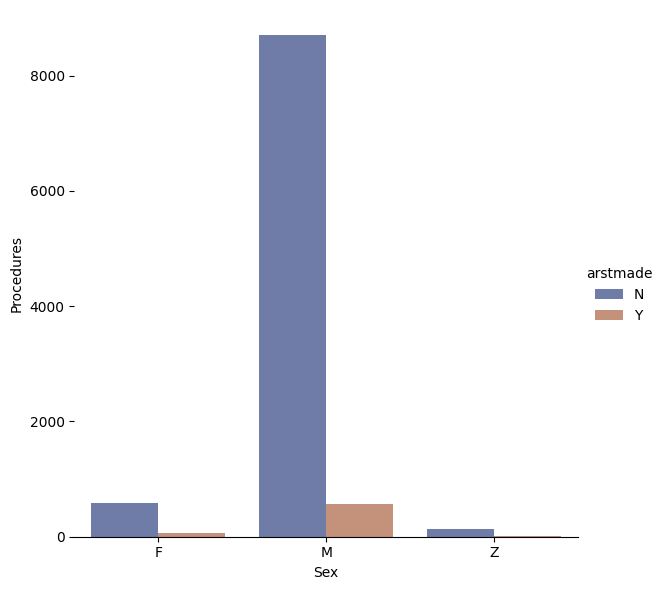

In [17]:
#grafico
g2 = sns.catplot(
    data=grouped_counts_by_sex, kind="bar",
    x="sex", y="count", hue="arstmade",
    errorbar="sd", palette="dark", alpha=.6, height=6
)
g2.despine(left=True)
g2.set_axis_labels("Sex", "Procedures")

Existe una gran tendencia en relacion al sexo de la persona en cuanto a las posibilidad de ser detenida tanto como de arresto, la diferencia es exponencialmente mayor si se es M que las otras opciones

Estudie la relación de la variable respuesta en comportamiento con la
sexo y la edad en su conjunto, comente.

<Axes: xlabel='age', ylabel='sex'>

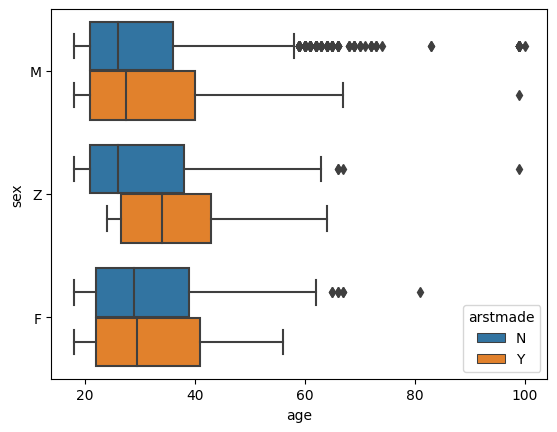

In [18]:
sns.boxplot(data=filtered_df, x="age", y="sex", hue="arstmade")

Son bastante similares los valores entre M y F sin embargo hay bastantes valores atipicos entre los procedimientos hechos a H, de igual manera la edad maxima en procedimientos en M que no llegan a arresto es mayor que en el caso de los hombres, de igual manera los arrestos entre M la edad maxima es mucho mayor que M, asi como la tendencia interesante que la media en M es algo mayor que H, igualmente Z tiene ciertas similitudes con M sin embargo me llama la atencion que entre los procedimientos que llegaron a arresto el 2do cuartil es basicamente la media de aquellos que no llegaron a un arresto

4.4 Recodifique la variable respuesta a 1 y 0. Donde 0 es N y 1 es Y

In [19]:
filtered_df['arstmade'].values

array(['N', 'N', 'N', ..., 'N', 'N', 'N'], dtype=object)

In [20]:
filtered_df['arstmade'] = filtered_df['arstmade'].replace({'N': 0, 'Y': 1})
filtered_df['arstmade'].values

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

5.- Determinar si el procedimiento policial concluirá en alguna acción violenta.
Los atributos que tienen el prefijo pf (['pf_hands'],['pf_wall'], ['pf_grnd'],
['pf_drwep'], ['pf_ptwep'],['pf_baton'],['pf_hcuff'], ['pf_pepsp'] y ['pf_other']) indican
si hubo fuerza fisica utilizada por el oficial al momento del procedimiento, con la
marca 'Y'.
Genere una nueva variable llamada 'violencia' la cual sea 1 si en cualquiera de
las 9 variables pf hubo alguna 'Y', y 0 en otro caso. Luego indique el porcentaje
de casos que terminaron con violencia.

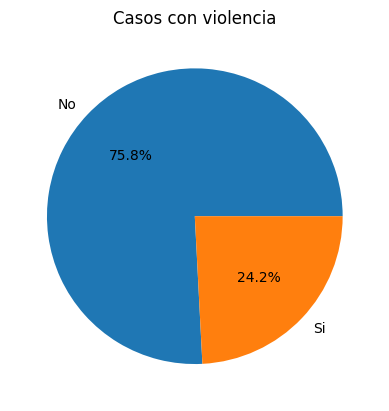

In [21]:
#criterios de violencia
def is_violent(row):
    #funcion para determinar si hubo accion violenta devuelve 1 sino devuelve 0
    COLUMNS = ['pf_hands','pf_wall','pf_grnd','pf_drwep','pf_ptwep','pf_baton','pf_hcuff','pf_pepsp','pf_other']
    for column in COLUMNS:
        if row[column] == 'Y':
            return 1
    return 0

filtered_df['violencia'] = filtered_df.apply(is_violent, axis=1)

grouped_counts = filtered_df['violencia'].value_counts()

total_count = grouped_counts.sum()
percentages = (grouped_counts / total_count) * 100

percentages_df = percentages.reset_index()
percentages_df.columns = ['Value', 'Percentage']
percentages_df['Value'] = percentages_df['Value'].replace({0: 'No', 1: 'Si'})

plt.pie(percentages_df['Percentage'], labels=percentages_df['Value'], autopct='%1.1f%%')

plt.title('Casos con violencia')

plt.show()

Es visible que 24% de los casos terminaron con violencia de alguna indole

● 6.1 Genere las variables dummies correspondientes (Tenga cuidado de no
utilizar variables que expliquen lo mismo, ¡recuerde que acaba de crear
una variable a partir de otras!, además recuerde que creó una variable
numérica que es una categoría :) ). Luego genere los sets de train-test
utilizando el año 2009 para entrenar, y el año 2010 para testear.

In [22]:
#Se descartan las columnas que dieron vida a la columna violencia
train_df = filtered_df.drop(['pf_hands','pf_wall','pf_grnd','pf_drwep','pf_ptwep','pf_baton','pf_hcuff','pf_pepsp','pf_other'], axis=1)
var_cat = train_df.select_dtypes('object').columns.to_list()
var_num = train_df.select_dtypes('number')
data_encoded = pd.get_dummies(train_df, columns=var_cat, drop_first=False)
data_train = data_encoded[data_encoded["datestop_year"] == 2009]
data_test  = data_encoded[data_encoded["datestop_year"] == 2010]

X_train, y_train = data_train.iloc[:, 1:], data_train["arstmade"]
X_test, y_test   = data_test.iloc[:, 1:], data_test["arstmade"]

print(f"Forma set de entrenamiento: X {X_train.shape}, y {y_train.shape}")
print(f"Forma set de prueba: X {X_test.shape}, y {y_test.shape}")

Forma set de entrenamiento: X (4987, 246), y (4987,)
Forma set de prueba: X (5091, 246), y (5091,)


In [23]:
#hacemos fit a los modelos
C = 1
svc = svm.SVC(kernel='linear', C=1).fit(X_train, y_train)
rbf_svc = svm.SVC(kernel='rbf', gamma=0.7, C=C).fit(X_train, y_train)
poly_svc = svm.SVC(kernel='poly', degree=3, C=C).fit(X_train, y_train)

In [24]:
#funcion de matriz de confusion
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalizada")
    else:
        print('Sin normalizacion')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Real')
    plt.xlabel('Predicho')

Linear
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      4749
           1       0.85      0.60      0.70       342

    accuracy                           0.97      5091
   macro avg       0.91      0.80      0.84      5091
weighted avg       0.96      0.97      0.96      5091

Sin normalizacion
[[4712   37]
 [ 136  206]]
RBF
              precision    recall  f1-score   support

           0       0.93      1.00      0.97      4749
           1       0.00      0.00      0.00       342

    accuracy                           0.93      5091
   macro avg       0.47      0.50      0.48      5091
weighted avg       0.87      0.93      0.90      5091

Sin normalizacion
[[4749    0]
 [ 342    0]]
Poly
              precision    recall  f1-score   support

           0       0.93      1.00      0.97      4749
           1       0.00      0.00      0.00       342

    accuracy                           0.93      5091
   macro avg       0.4

c:\Users\Jose Duarte\Documents\Aspasia\codigo\.venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Jose Duarte\Documents\Aspasia\codigo\.venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Jose Duarte\Documents\Aspasia\codigo\.venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

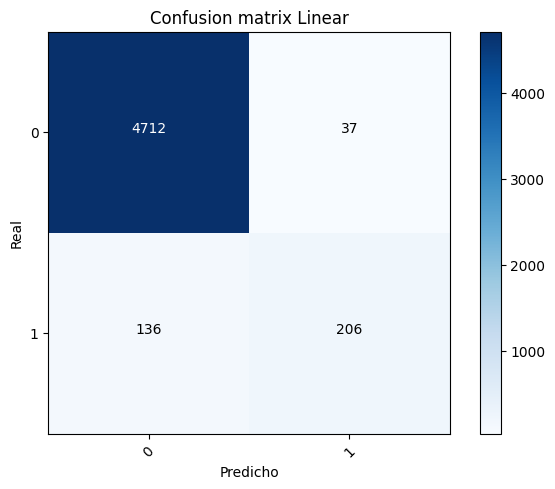

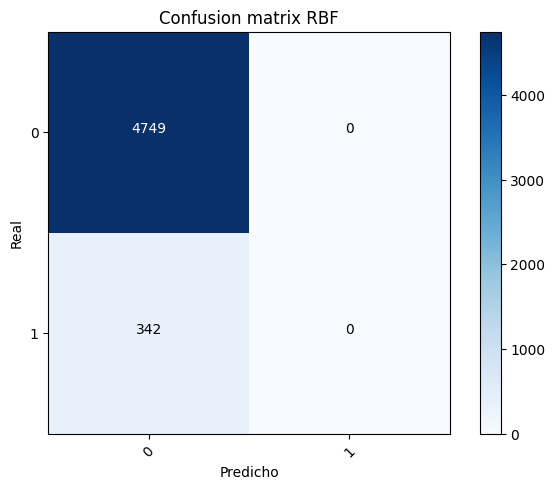

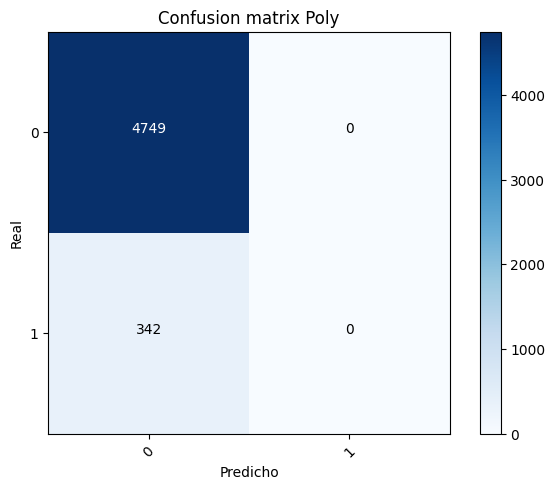

In [28]:
y_hat_linear = svc.predict(X_test)
y_hat_rbf = rbf_svc.predict(X_test)
y_hat_poly = poly_svc.predict(X_test)

#Matrices de Confusion

for i in [(y_hat_linear, 'Linear'), (y_hat_rbf, 'RBF'), (y_hat_poly, 'Poly')]:
    print(i[1])
    cnf_matrix = confusion_matrix(y_test, i[0], labels=[0,1])
    np.set_printoptions(precision=2)
    print (classification_report(y_test, i[0]))

    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=['0', '1'],normalize= False,  title=f'Confusion matrix {i[1]}')

Despues de entrenar los modelos y usar 3 tipos de clasificacion, SVF el que tiene mas aciertos en predecir cuales procedimientos pueden terminar con algun tipo de violencia seria el del SVC con kernel linear, curiosamente los otros terminaban en verdaderos falsos.